# Rotation invariant Object Detection

### v0.6
1. Now, per frame data are being exported in CSV 
2. Specific frames can be selected for computation

### v0.5
1. Singularization based on confidence (after match templating)
2. individual colors (fixed for all systems)
3. Individual rotation angles plot
4. individual rotations added into CSV

### v0.4
1. Seperated shapes to create templates
2. Implemented thesholding and contouring
3. Applied matching template on contours
4. trajectory output functionality added
5. CSV output polished
6. x, y coordinates added to output csv

### Shortcomings
1. Sometimes it misses the detection

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import datetime
import time
import os
import csv

### Initialization

In [2]:
# Set the current directory of your Microswimmer project (Absolute address)
current_dir = "D:/02_Works/01_Projects/Microswimmer/Microswimmer_data/"
# set target directory where the images are located (relative to the current directory)
tar_dir = "data/Chiral shapes/20210528-rotor-3-1/Movie10_"
# Set location to save results and data (relative to the current directory)
save_dir = "Results/"
video_filename = '20210528-rotor-3-1'

# Set true to get video or image, False otherwise
image_out = True
video_out = True 

init = 977           # Start number of image
start_n = 0              
end_n = 10             # Number of images in the directory
thresh = 0.6        # Threshold value for Template matchin
rot_interval = 1    # Degree of rotation to match rotated templates
gray_threshold = 148    # Thresholding the image
af = 1


#micron_per_pixel is a microscope calibration parameter. This will be fixed for a given experiment. Do NOT change.
micron_per_pixel = 100/30.

blur_size = (5,5)

red_color = (0,0,255)
green_color = (0,255,0)
blue_color = (255,0,0)
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 0.5
font_thick = 2

# Define specific color for particles in order
# Optimally distinct colors
colors = ["#e95723",
"#2c7fb3",
"#30a530",
"#9866b9",
"#d62728",
"#9f5200",
"#ffa741"]

In [3]:
# TimeStamp as folder

import re

new_dir = datetime.datetime.now()
new_dir = re.sub("[^0-9]", "", str(new_dir))
new_dir = new_dir[:8]+'_'+new_dir[8:14]


### Necessary Functions

In [4]:
def rotate_image(image, angle):
    h, w = image.shape[:2]
    cx, cy = (w // 2, h// 2)

    # get rotation matrix
    rotMat = cv2.getRotationMatrix2D((cx, cy), -angle, 1.0)

    # get cos and sin value from the rotation matrix
    cos, sin = abs(rotMat[0, 0]), abs(rotMat[0, 1])

    # calculate new width and height after rotation
    newW = int((h * sin) + (w * cos))
    newH = int((h * cos) + (w * sin))

    # Calculate new rotation center
    rotMat[0, 2] += (newW / 2) - cx
    rotMat[1, 2] += (newH / 2) - cy

    # use modified rotation center and rotatin matrix in the warpAfiine method
    result = cv2.warpAffine(image, rotMat, (newW, newH), borderValue=(0,0,0), flags=cv2.INTER_LINEAR)

    # pixel_array = np.full((h, w, 1), (255), dtype=np.uint8)
    # mask = cv2.warpAffine(pixel_array, rotMat, (newW, newH))

    # cv2.imshow('result', result)
    # cv2.imshow('g', mask)
    # cv2.waitKey(0)

    return result, newW, newH



def singularization(array, threshold):
    singularized_points = []
    n = len(array)
    taken = [False] * n
    for i in range(n):
        if not taken[i]:
            point = array[i]
            taken[i] = True
            for j in range(i+1, n):
                
                point_10 = array[i][0][0]
                point_11 = array[i][0][1]
                point_20 = array[j][0][0]
                point_21 = array[j][0][1]
                # print(f'10: {point_10} \n11: {point_11} \n20: {point_20} \n21: {point_21}')
                dist = math.sqrt((point_10 - point_20)*(point_10 - point_20) + (point_11 - point_21)*(point_11 - point_21))
                # print(f'distance: {dist}')
                # print(f'threshold {threshold}')
                if dist <= threshold:
                    # if confidence_i < confidence_j:
                    point = array[j]
                    #     # print(f' array[j][0]: {point}')
                    taken[j] = True


            singularized_points.append(point)

    return singularized_points

def singularization_conf(array):
    n = len(array)
    max_arr = 0
    for i in range(n):
        if array[i][2] > max_arr:
            max_arr = array[i][2]
            result = [array[i]]
    try:
        return result
    except:
        return None

# Function to calculate polar coordinates: (x,y) -> r, theta
def xy2polar(x, y):
    r = (x**2 + y**2)**0.5
    theta = np.arctan2(y, x)/3.1416*180
    return r, theta

def get_corners(bboxes):
    ''' Get corners of bounding boxes

    parameters:
    bboxes: numpy.ndarray
        Numpy array that contains bounding boxes of shape 'N x 4' where
        N is the number of bounding boxes and the bounding boxes are represented in
        the format 'x1 y1 x2 y2'

    returns
    numpy.ndarray
        Numpy array of shape 'N x 8' containing N bounding boxes each described by 
        their corner co-ordinates 'x1 y1 x2 y2 x3 y3 x4 y4'

    '''

    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)

    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)

    x2 = x1 + width
    y2 = y1

    x3 = x1
    y3 = y1 + height

    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)

    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))

    return corners


def rotate_bb(corners, angle, cx, cy, h, w):
    '''Rotate the boundin box.

    Parameters
    -----------
    corners: numpy.ndarray
        Numpy array of shape 'N x 8'
        all the corners - 'x1 y1 x2 y2 x3 y3 x4 y4'

    angle: float
        The image is gonna be rotated by this angle

    cx: int
        x coordinate of the center of the image to be rotated
    
    cy: int
        y coordinate of the center of the image to be rotated

    h: int
        height of the image
    
    w: int
        width of the image

    Returns
    --------
    numpy.ndarray
        in 'N x 8' shape where N is the number of bounding boxes and
        8 parameters of corners like 'x1 y1 x2 y2 x3 y3 x4 y4'    
    '''

    corners = corners.reshape(-1, 2)
    corners = np.hstack((corners, np.ones((corners.shape[0], 1), dtype= type(corners[0][0]))))

    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)

    cos = np.abs(M[0,0])
    sin = np.abs(M[0,1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated


def round_up_to_odd(f):
    result = int(np.ceil(f) // 2 * 2 + 1)
    return  result if result >= 3 else 3

def color_shift(color_a, color_b, percentage):
    # 'color_a' and 'color_b' are RGB tuples
    # color_a --> color_b
    # 't' is a value between 0.0 and 1.0
    # this is a naive interpolation
    return tuple(int(a + (b - a) * percentage) for a, b in zip(color_a, color_b))

def hex2bgr(hex):
    '''
    convert hex to bgr

    input: hex tuple
    output: bgr tuple
    '''
    hex = hex.lstrip('#')
    bgr = tuple(int(hex[i:i+2], 16) for i in (4, 2, 0))
    return bgr

### Thresholding

In [5]:
def thresholding(img, gray_thresh):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_clone = img.copy()
    wndw = "thresholding"
    cv2.imshow(wndw, img)
    def nothing(x):
        pass

    cv2.createTrackbar('threshold', wndw, gray_thresh, 255, nothing)

    while(True):
        
        k = cv2.waitKey(1) & 0xFF
        if k == 32:                                             # Pressing 'Space' key closes the window and go to next phase
            break
        gray_thresh = cv2.getTrackbarPos('threshold', wndw)
        
        _, img = cv2.threshold(img_clone, gray_thresh, 255, cv2.THRESH_BINARY)
        cv2.imshow(wndw, img)
    cv2.destroyAllWindows()
    return img, gray_thresh

### GUI multiple template cropping tool


In [6]:
class GUI_crop:
    def __init__(self):
        self.box_points = []
        self.num_points = []
        self.button_down = False
        self.numbering = 1
        self.boxed_img = []
        self.temp_img = []

    # mouse pressing function
    def crop(self, event, x, y, flags, param):    # cropping the template from the main image
        
        # Mouse was not pressed, but you are pressing now
        if (self.button_down == False) and (event == cv2.EVENT_LBUTTONDOWN):
            self.button_down = True
            self.box_points = [(x, y)]   # registers the first point you pressed
            self.num_points = [(x - 10, y - 10)]

        # Mouse is pressed and you are moving it, this makes rectangle by
        # using the first point and last point you have moved to.
        elif (self.button_down == True) and (event == cv2.EVENT_MOUSEMOVE):
            self.temp_img = param.copy()
            point = (x, y)
            cv2.rectangle(self.temp_img, self.box_points[0], point, blue_color, 2)
            c_x = (self.box_points[0][0] + point[0])//2
            c_y = (self.box_points[0][1] + point[1])//2
            cv2.circle(self.temp_img, (c_x, c_y), 1, red_color, 2)
            cv2.putText(self.temp_img, str(self.numbering), self.num_points[0],
                        font, font_size, blue_color, font_thick)
            cv2.imshow("Template Cropper - Press C to Crop", self.temp_img)

        # you are no longer pressing the mouse
        elif event == cv2.EVENT_LBUTTONUP:
            self.button_down = False
            self.box_points.append((x, y))
            cv2.rectangle(self.temp_img, self.box_points[0], self.box_points[1], blue_color, 2)
            # cv2.circle(self.temp_img, (c_x, c_y), 2, blue_color, 2)
            cv2.putText(self.temp_img, str(self.numbering), self.num_points[0],
                        font, font_size, blue_color, font_thick)
            cv2.imshow("Template Cropper - Press C to Crop", self.temp_img)

    def template_crop(self, image, image_col, num_shapes):
        clone = image.copy()
        self.boxed_img = image_col.copy()

        templates_region = []
        templates_area = []
        templates_midpoint = []

        cv2.imshow("Template Cropper - Press C to Crop", self.boxed_img)
        def nothing(x):
            pass
        cv2.createTrackbar('Gray Threshold', "Template Cropper - Press C to Crop", gray_threshold, 255, nothing)

        for i in range(0, num_shapes):
            # cv2.namedWindow("Template Cropper - Press C to Crop")
            cv2.imshow("Template Cropper - Press C to Crop", self.boxed_img)
            self.box_points = []
            self.numbering = i

            while True:
                cv2.setMouseCallback("Template Cropper - Press C to Crop", self.crop, self.boxed_img)
                # cv2.imshow("Template Cropper - Press C to Crop", self.boxed_img)
                time.sleep(0.05)
                key = cv2.waitKey(1)
                if key == ord("c"):
                    self.boxed_img = self.temp_img.copy()
                    cv2.destroyAllWindows()
                    break
            
            if len(self.box_points) == 2:
                y1 = self.box_points[0][1]
                y2 = self.box_points[1][1]
                x1 = self.box_points[0][0]
                x2 = self.box_points[1][0]
                cropped_region = clone[y1:y2, x1:x2]
                cropped_area = [abs(x1 - x2), abs(y1 - y2)]
                midpoints = [(x1 + x2)//2, (y1 + y2)//2]
                # cv2.circle(self.boxed_img, midpoints, 2, green_color, 2)

            templates_region.append((cropped_region))
            templates_area.append((cropped_area))
            templates_midpoint.append((midpoints))
            
    
            # print(f"Templates Region {templates_region}")
            # print(f"templates_area {templates_area}")

        return templates_region, templates_area, templates_midpoint, self.box_points

### Thresholding + Contour

In [7]:
class sliding:
    def __init__(self):
        # self.ini = init
        self.tempP1 = 255
        self.tempP2 = 199
        self.tempP3 = 5


    def sliding(self, img):
        img_clone = img.copy()
        blank_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)

        
        def nothing(x):
            pass

        wndw = 'thresholding testing'
        cv2.namedWindow(wndw, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(wndw, (600, 600))
        cv2.imshow(wndw, blank_img)
        

        cv2.createTrackbar('maxValue', wndw, self.tempP1, 255, nothing)
        cv2.createTrackbar('blockSize', wndw, self.tempP2, 255, nothing)
        cv2.createTrackbar('C', wndw, self.tempP3, 255, nothing)

        # loop of sliding and updating the variables in the image
        while(True):
            cv2.imshow(wndw, blank_img)
            k = cv2.waitKey(1) & 0xFF
            if k == 32:
                break

            # img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            # blank_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)

            maxVal = cv2.getTrackbarPos('maxValue', wndw)
            blckSize = cv2.getTrackbarPos('blockSize', wndw)
            blckSize = round_up_to_odd(blckSize)
            c = cv2.getTrackbarPos('C', wndw)
    
            try:
                blank_img = self.threshCont(img, maxVal, blckSize, c)

            except Exception as e:
                print(f'exception: {e}')

       #blank_img2 = self.threshCont(img2, maxVal, blckSize, c)
        
        cv2.destroyAllWindows()
        return blank_img, maxVal, blckSize, c
    
    def threshCont(self, img, maxVal, blckSize, c):
        blank_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
        img = cv2.adaptiveThreshold(img, maxVal, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, blckSize, c)
        img = cv2.bitwise_not(img)
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(blank_img, contours, -1, (0, 255,0), 1)
        return blank_img
    

### Match Templating Function

In [8]:
def matchTemplate(image, template, thresh, rot_range, rot_interval):
    # to keep track of the best matches
    best_matches = []

    for angle in range(0, rot_range, rot_interval):
        rotated_template, x, y = rotate_image(template, angle)
        result = cv2.matchTemplate(image, rotated_template, cv2.TM_CCOEFF_NORMED)

        # loc = np.where(result >= thresh)
        # for pt in zip(*loc[::-1]):
        #     best_matches.append((pt, angle))

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        if max_val >= thresh and not math.isinf(max_val):
            best_matches.append([max_loc, angle, max_val, x, y])

    return best_matches

In [9]:
def multi_img_check(img, img_col, templates_region, templates_area, templates_midpoint):
    img_h, img_w = img.shape[:2]
    c_h = img_h//2
    c_w = img_w//2
    output = []
    angles = []
            

    for i in range(len(templates_midpoint)):
        # Selecting the maximum length of the template
        max_length = max(templates_area[i][0], templates_area[i][1])
        min_length = min(templates_area[i][0], templates_area[i][1])

        # following code creates 2 points of making a rectangle
        # t_x1 and t_y1 are the (x,y) of the furthest left-up point of the rectangle
        # t_x2 and t_y2 are the (x,y) of the furthest right-down point of the rectangle
        t_x1 = 0 if (templates_midpoint[i][0] - max_length) < 0 else (templates_midpoint[i][0] - max_length)
        t_y1 = 0 if (templates_midpoint[i][1] - max_length) < 0 else (templates_midpoint[i][1] - max_length)
        t_x2 = min(img_w, (templates_midpoint[i][0] + max_length*af))
        t_y2 = min(img_h, (templates_midpoint[i][1] + max_length*af))
        # print(t_x2, t_y2)

        # target_points.append([[t_x1, t_y1], [t_x2, t_y2]])
        # print(target_points)

        clone = img_col.copy()
        cv2.rectangle(clone, (t_x1, t_y1), (t_x2, t_y2), green_color, 2)
        cv2.imshow("Testing target box", clone)
        cv2.waitKey(100)
        # cv2.destroyAllWindows()

        target_img = img[t_y1:t_y2, t_x1:t_x2]

        # cv2.imshow("Testing of region validity", templates_region[i])
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        val = 0
        while True:
            result = matchTemplate(target_img, templates_region[i], thresh - val, 360, rot_interval)
            # result = singularization(result, min_length)
            result = singularization_conf(result)
            val += 0.05
            if result:
                print(result)
                break
        # print(templates_points)

        # Drawing bounding box around the matches
        # h, w = templates_region[i].shape
        
        ### Individual color for each particles
        white = (255, 255, 255)
        black = (0,0,0)
        col = hex2bgr(colors[i])
        bright_col = color_shift(col, white, 0.30)
        dark_col = color_shift(col, black, 0.3)
        
        for (pt, angle, max_val, p_x, p_y) in result:
            pt1 = (pt[0] + t_x1, pt[1] + t_y1)
            pt2 = (pt1[0] + p_x, pt1[1] + p_y)
            # print(type(pt1[0]))

            # Rotating bounding box implemented here
            bbox = np.array([[pt1[0], pt1[1], pt2[0], pt2[1]]])
            bbcorner = get_corners(bbox)
            # cv2.rectangle(img_col, pt1, pt2, blue_color, 1)
            t_c_x = (pt1[0] + pt2[0])//2      # center of the rectangle from x axis
            t_c_y = (pt1[1] + pt2[1])//2      # center of the rectangle from y axis
            cornerAll = rotate_bb(bbcorner, (-1)*angle, t_c_x, t_c_y, templates_region[i].shape[0], templates_region[i].shape[1])
            cornerAll = cornerAll.reshape(4,2)
            pts = [cornerAll[0], cornerAll[1], cornerAll[3], cornerAll[2]] + np.array(pt1)
            img_col = cv2.polylines(img_col, np.int32([pts]),
                                    True, dark_col, 2)

            cv2.circle(img_col, (t_c_x, t_c_y), 1, dark_col, 2)
            cv2.line(img_col, (c_w, c_h), (t_c_x, t_c_y), bright_col, 1)
            _, t_theta = xy2polar(c_w - t_c_x, c_h - t_c_y)
            
            cv2.putText(img_col, str(round(180 - t_theta)), ((c_w + t_c_x)//2, (c_h + t_c_y)//2), font,
                        font_size, bright_col, font_thick)      ### Angle theta = angle for every particle respect to the center
            
            cv2.putText(img_col, str(360 - angle), (t_c_x, t_c_y), font,
                        font_size, col, 1)      ### angle omega = angle on individual axis

            

        
        output.append([t_c_x, t_c_y])
        angles.append(str(360 - angle))
        
        

    cv2.imshow("Testing", img_col)
    # video.write(img_col)
    cv2.waitKey(10)
    

    return output, img_col, angles


### Main Function

In [10]:
os.chdir(current_dir + save_dir)
try:
    os.mkdir(new_dir)
except:
    pass
os.chdir(current_dir + save_dir + new_dir)

In [11]:
start = time.time()
midpoints = []
list_dict = ['time']
t = np.linspace(0, end_n-1, end_n)
t = t*0.05  #"0.05" is time calibration, it converts the unit to seconds. do NOT change this. 


for j in range(start_n, end_n):
    img_bgr = cv2.imread(current_dir + tar_dir + str(init + j)+".tif")
    img_color = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    # _, img_gray = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY)

    assert img_color is not None, "Image does not exist"

    threshCont = sliding()
    

    if j == 0:
        # How many shapes are there in the image?
        num_shapes = int(input("How many individual shapes are there in the image? Ans: "))

        # Thresholding
        # img_gray, gray_threshold = thresholding(img_color, gray_threshold)

        # Thresholding + Contour
        img_gray, maxV, blckSz, c = threshCont.sliding(img_gray)

        # Crop the shapes individually
        crop = GUI_crop()
        templates_region, templates_area, templates_midpoint, templates_points = crop.template_crop(img_gray, img_gray, num_shapes)
        for x in range(num_shapes):
            list_dict += [f'p{x}_x', f'p{x}_y', f'p{x}_theta', f'p{x}_omega']
        with open(f'{video_filename}.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(list_dict)
            file.close()
    else:
        # img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
        # _, img_gray = cv2.threshold(img_gray, gray_threshold, 255, cv2.THRESH_BINARY)
        img_gray = threshCont.threshCont(img_gray, maxV, blckSz, c)

    midpoint, img_out, angle_per_frame = multi_img_check(img_gray, img_gray, templates_region, templates_area, 
                                    templates_midpoint if j == 0 else midpoints[j-1])
    midpoints.append(midpoint)
    
    #Find the center of the large circle in the image
    x, y = img_color.shape[:2]
    c_x = x//2
    c_y = y//2
    

    m = np.array(midpoint)
    dict = []
    with open(f'{video_filename}.csv', 'a', newline='') as file_n:
        for i in range(num_shapes):
            _, theta = xy2polar((m[i, 0]-c_x)*micron_per_pixel, (m[i, 1]-y)*micron_per_pixel)
            dict += [m[i, 0], m[i, 1], str(round(180-theta)), angle_per_frame[i]]
            # print(f'dict: {dict}')        ### diagnosis
        writer = csv.writer(file_n)
        writer.writerow([t[j]] + dict)
        file_n.close()

    print(f"j = {j}; midpoint : {midpoint}")
    
end = time.time()
cv2.destroyAllWindows()

print(f'elapsed time: {end - start} sec')



[[(54, 21), 359, 0.7264712452888489, 110, 108]]
[[(57, 55), 0, 0.8016956448554993, 105, 110]]
[[(55, 54), 0, 0.9999999403953552, 106, 108]]
j = 0; midpoint : [[130, 75], [345, 194], [214, 301]]
[[(34, 15), 344, 0.6378709077835083, 134, 132]]
[[(50, 50), 5, 0.6590681076049805, 114, 118]]
[[(10, 41), 348, 0.6620283722877502, 126, 127]]
j = 1; midpoint : [[122, 81], [342, 193], [179, 297]]
[[(32, 8), 327, 0.5715258121490479, 149, 149]]
[[(50, 52), 11, 0.618055522441864, 124, 128]]
[[(18, 30), 336, 0.5849711298942566, 140, 141]]
j = 2; midpoint : [[119, 82], [344, 199], [159, 289]]
[[(28, 12), 313, 0.5885443091392517, 152, 152]]
[[(39, 59), 17, 0.5960452556610107, 132, 135]]
[[(20, 29), 321, 0.5276603698730469, 150, 150]]
j = 3; midpoint : [[114, 88], [339, 215], [146, 285]]
[[(39, 12), 298, 0.5348776578903198, 145, 146]]
[[(37, 48), 23, 0.6052889823913574, 139, 142]]
[[(26, 27), 304, 0.4856417179107666, 148, 148]]
j = 4; midpoint : [[116, 85], [335, 224], [138, 278]]


KeyboardInterrupt: 

In [ ]:
# save elapsed time for future debugging
os.chdir(current_dir + save_dir + new_dir)
with open('info.txt', 'w') as f:
    f.write(f'Elapsed time for main function : {end - start}')

### Trajectory mapping

In [ ]:
def trajectory(img_col, midpoints):

    # col = [red_color, green_color, blue_color, (237, 79, 166), (11, 75, 75), (226, 231, 61), (150, 130, 245)]
    blank = 255 * np.ones((img_col.shape[0], img_col.shape[1], 3), dtype=np.uint8)
    for each in midpoints:
        for i in range(len(each)):
            c_x = each[i][0]
            c_y = each[i][1]

            # Trajectory points
            cv2.circle(blank, (c_x, c_y), radius=3,
                        color=hex2bgr(colors[i]), thickness=-1)
            
        # cv2.imshow('trajectory', blank)
        # cv2.waitKey(1)
        
    return blank

### Trajectory Mapping showcase

In [ ]:
cv2.destroyAllWindows()

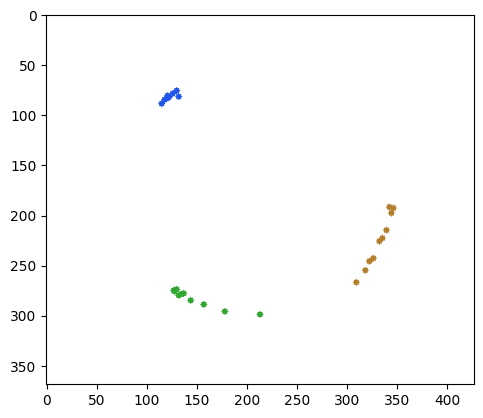

In [ ]:
trail = trajectory(img_gray, midpoints)
plt.imshow(trail)
plt.savefig(video_filename + '.png', dpi=500)
os.chdir(current_dir)

### Making Images and Video

In [ ]:
if image_out:
        os.chdir(current_dir + save_dir + new_dir)
        if not os.path.exists(video_filename):
                os.mkdir(video_filename)
                os.chdir(video_filename)
        else:
                max_n = 0
                for filename in os.listdir():
                        if os.path.isdir(filename) and video_filename in filename:
                                if filename[-1].isdigit():
                                        if int(filename[-1]) > max_n:
                                                max_n = int(filename[-1])
                                                last_dir = filename
                                                print(last_dir)
                                else:
                                        last_dir = filename + "0"
                # Check if the existing folder has numbering in it or not
                # If there is number than just adds 1 to it
                # If there is none, than places 1
                if last_dir[-1].isdigit():
                        val = int(last_dir[-1]) + 1
                        os.mkdir(video_filename + str(val))
                        os.chdir(video_filename + str(val))
                else:
                        os.mkdir(video_filename + "1")
                        os.chdir(video_filename + "1")
        count = 0
        for image in img_stack:
                cv2.imwrite(video_filename + str(count) + '.jpg', image)
                count += 1
        

if video_out:
        os.chdir(current_dir + save_dir + new_dir)
        video = cv2.VideoWriter(video_filename + ".mp4", cv2.VideoWriter_fourcc(*'MP4V'), 20, (img_gray.shape[1], img_gray.shape[0]))

        count = 0
        for image in img_stack:              
                video.write(image)
                count += 1
        video.release()

In [ ]:
bboxes = np.array([[1,5,6,7],
                    [2,10,8,9],
                    [3,11,12,13],
                    [4,14,15,16]])

print(bboxes[:, 2].reshape(-1,1))

[[ 6]
 [ 8]
 [12]
 [15]]


### Polar conversion of cartesian co-ordinates

In [ ]:
r = np.empty([num_shapes, N])
theta = np.empty([num_shapes, N])

#Find the center of the large circle in the image
x, y = img_color.shape[:2]
c_x = x//2
c_y = y//2

x_data = []
y_data = []

# It basically takes every (x, y) -> converts into (r, theta)
for i in range(num_shapes):         # Loops for number of circles previously defined
        for k in range(N):                      # Number of images scanned = that number of data points
            x = midpoints[k][i][0]
            y = midpoints[k][i][1]
            x_data.append(x)
            y_data.append(y)
            r[i][k], theta[i][k] = xy2polar((x-c_x)*micron_per_pixel, (c_y-y)*micron_per_pixel)

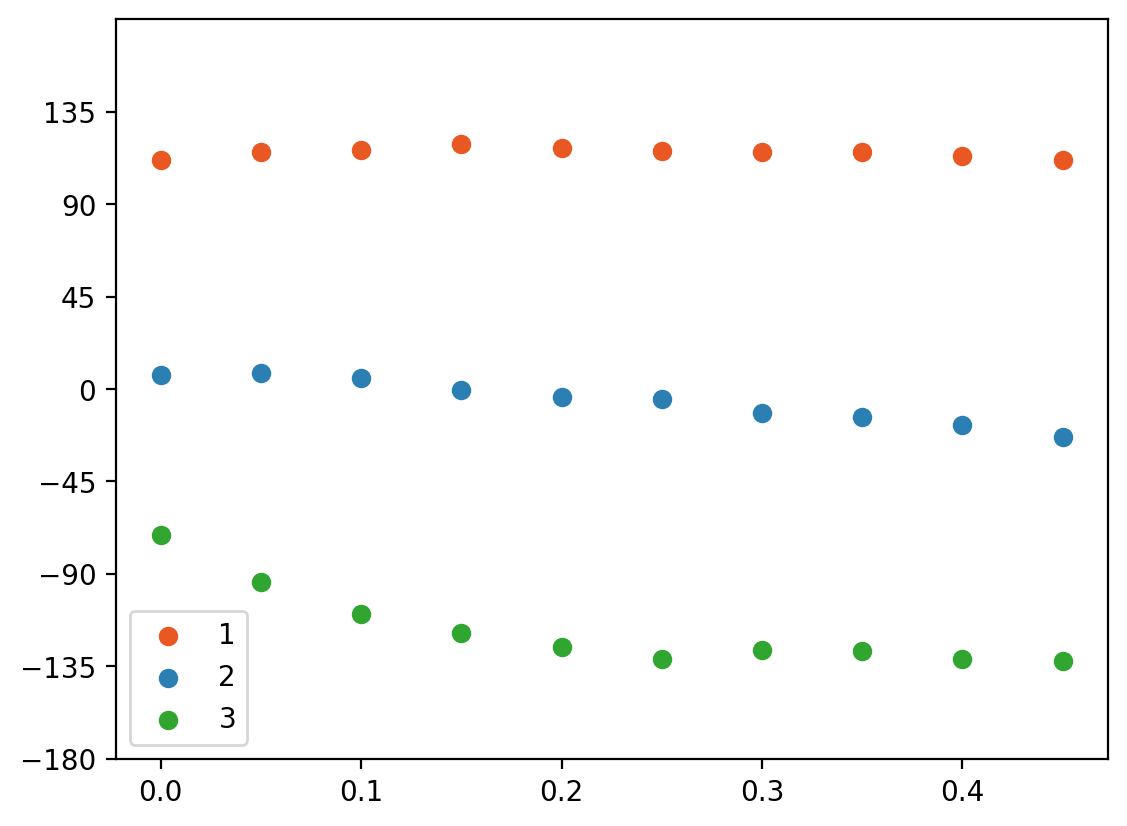

In [ ]:
plt.figure(dpi=200)
plt.ylim(-180, 180)
plt.yticks(np.arange(-180, 180, 45))
legend = []

t = np.linspace(0, N-1, N)
t = t*0.05  #"0.05" is time calibration, it converts the unit to seconds. do NOT change this. 

for i in range(len(theta)):
    plt.scatter(t, theta[i], c=colors[i])    # For Every shape
   
    legend.append(str(i+1))

# plt.xlim(0,20)
plt.legend(legend)

os.chdir(current_dir + save_dir + new_dir)
plt.savefig('video_filename'+'Angular_data.png')

ValueError: x and y must be the same size

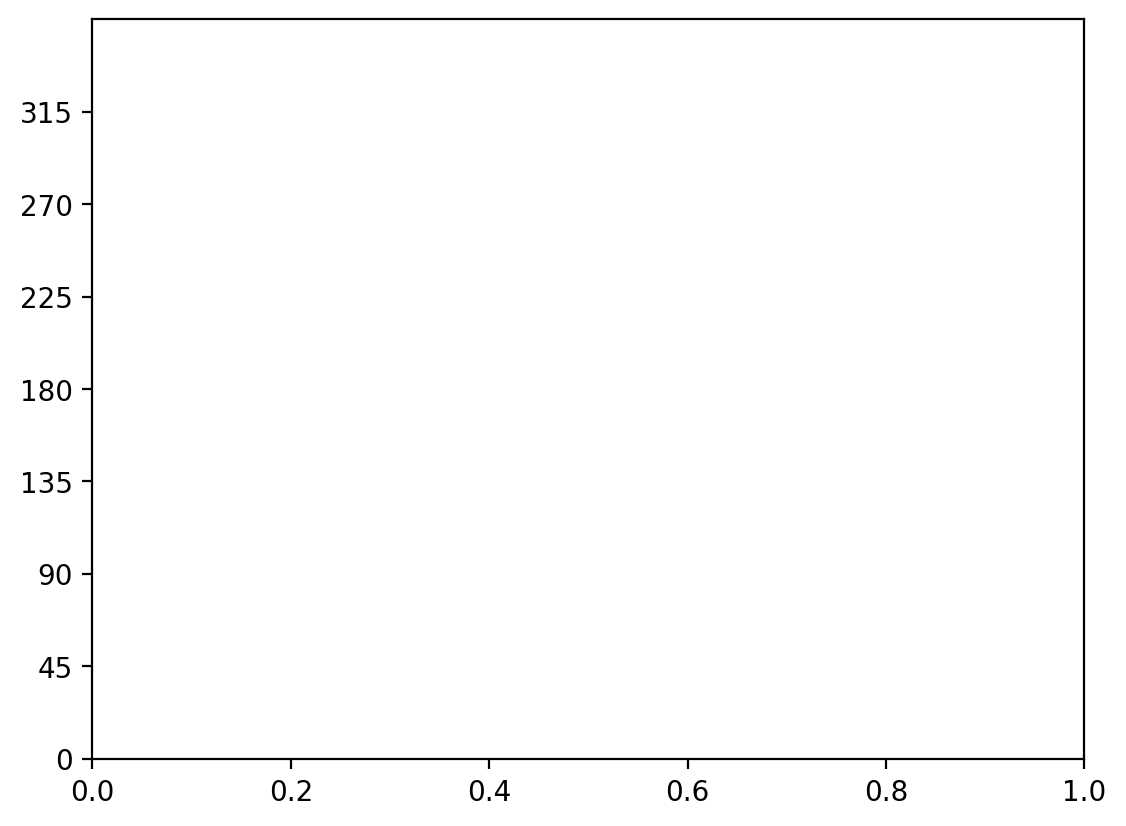

In [ ]:
plt.figure(dpi=200)
plt.ylim(0, 360)
plt.yticks(np.arange(0, 360, 45))
legend = []
angles = np.array(angles)

for i in range(len(theta)):
    plt.scatter(t, angles[:,i], c=colors[i])    # For Every shape

    legend.append(str(i+1))

# plt.xlim(0,20)
plt.legend(legend)

os.chdir(current_dir + save_dir + new_dir)
plt.savefig('video_filename'+'Angular_data_omega.png')

### Exporting the data into CSV file

In [ ]:
angles = np.array(angles)
angles[:, 0, 2]
len(angles)

19

In [ ]:
m = np.array(midpoints)
len(m)

19

In [ ]:
dict = {'time': t[:len(m)]}
for i in range(len(m[0])):
    dict[f'p{i}_x'] = m[:, i, 0]
    dict[f'p{i}_y'] = m[:, i, 1]
    dict[f'p{i}_theta'] = theta[i, :len(m)]
    dict[f'p{i}_omega'] = angles[:, 0, i]

In [ ]:
dict

{'time': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
 'p0_x': array([336, 371, 390, 411, 437, 451, 462, 473, 480, 489, 495, 499, 501,
        500, 502, 501, 501, 505, 497]),
 'p0_y': array([ 91, 104, 107, 124, 144, 152, 175, 191, 201, 226, 239, 246, 258,
        267, 286, 295, 298, 319, 335]),
 'p0_theta': array([ 77.10933906,  66.6909988 ,  61.60683652,  54.23700257,
         45.19411655,  40.98238312,  33.99637965,  28.65424706,
         25.21566233,  18.17407757,  14.56365853,  12.15088263,
          8.88892169,   6.51978651,   1.35106192,  -1.36392434,
         -2.1816363 ,  -7.71735171, -12.38072798]),
 'p0_omega': array([ 0,  3,  7, 11, 15, 20, 24, 27, 31, 34, 38, 41, 44, 48, 53, 58, 63,
        67, 73]),
 'p1_x': array([490, 495, 497, 491, 489, 481, 471, 467, 458, 446, 450, 439, 431,
        434, 418, 410, 403, 386, 380]),
 'p1_y': array([264, 293, 312, 338, 351, 373, 393, 402, 415, 427, 424, 

In [ ]:
import pandas as pd

df = pd.DataFrame(dict)

In [ ]:
print(df)

    time  p0_x  p0_y   p0_theta  p0_omega  p1_x  p1_y   p1_theta  p1_omega  \
0   0.00   336    91  77.109339         0   490   264   8.332541         0   
1   0.05   371   104  66.690999         3   495   293   0.000000       349   
2   0.10   390   107  61.606837         7   497   312  -5.321009       336   
3   0.15   411   124  54.237003        11   491   338 -12.804236       320   
4   0.20   437   144  45.194117        15   489   351 -16.752828       304   
5   0.25   451   152  40.982383        20   481   373 -22.941936       290   
6   0.30   462   175  33.996380        24   471   393 -29.571189       277   
7   0.35   473   191  28.654247        27   467   402 -32.300340       265   
8   0.40   480   201  25.215662        31   458   415 -36.702769       249   
9   0.45   489   226  18.174078        34   446   427 -41.238466       234   
10  0.50   495   239  14.563659        38   450   424 -40.055832       220   
11  0.55   499   246  12.150883        41   439   435 -44.604759

In [ ]:
os.chdir(current_dir + save_dir + new_dir)
df.to_csv(video_filename + '.csv', index=False)